# Penyeimbangan data Ecoli

In [2]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
fitur = ["mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2"]

def remove_empty(data):

    hasil = []

    for kal in range(len(data)):
        a = np.array(data[kal].split(" "))
        hasil.append(a[a != ''])

    return pd.DataFrame(hasil, columns=["name", "mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2", "class"])


In [4]:
ecoli_df = 0

with open("ecoli.data") as file:
    a = np.array(file.read().splitlines())
    ecoli_df = remove_empty(a)

ecoli_df

,name,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,AAT_ECOLI,0.49,0.29,0.48,0.50,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.50,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.50,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.50,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.50,0.55,0.25,0.35,cp
...,...,...,...,...,...,...,...,...,...
331,TREA_ECOLI,0.74,0.56,0.48,0.50,0.47,0.68,0.30,pp
332,UGPB_ECOLI,0.71,0.57,0.48,0.50,0.48,0.35,0.32,pp
333,USHA_ECOLI,0.61,0.60,0.48,0.50,0.44,0.39,0.38,pp
334,XYLF_ECOLI,0.59,0.61,0.48,0.50,0.42,0.42,0.37,pp


In [ ]:
import mysql.connector as myconnector

conn = myconnector.connect(
    host="localhost",
    port=3306,
    user="root",
    password="",
    database="imbalance"
)

cursor = conn.cursor()

cursor.execute('''DROP TABLE IF EXISTS ecoli_data''')
cursor.execute('''
    CREATE TABLE ecoli_data (
        id INT PRIMARY KEY AUTO_INCREMENT,
        name VARCHAR(50),
        mcg DECIMAL(5, 2),
        gvh DECIMAL(5, 2),
        lip DECIMAL(5, 2),
        chg DECIMAL(5, 2),
        aac DECIMAL(5, 2),
        alm1 DECIMAL(5, 2),
        alm2 DECIMAL(5, 2),
        class VARCHAR(3)
    )
''')

conn.commit()

In [8]:
for data_index in range(ecoli_df.shape[0]):
    data = ecoli_df.iloc[data_index]
    values = f"VALUES('{data['name']}', {data['mcg']}, {data['gvh']}, {data['lip']}, {data['chg']}, {data['aac']}, {data['alm1']}, {data['alm2']}, '{data['class']}')"
    cursor.execute(f"INSERT INTO ecoli_data(name, mcg, gvh, lip, chg, aac, alm1, alm2, class) {values}")

conn.commit()
cursor.close()
conn.close()

## Distribusi Kelas Pada Data Ecoli

Text(0.5, 1.0, 'Distribusi Kelas di Data Ecoli')

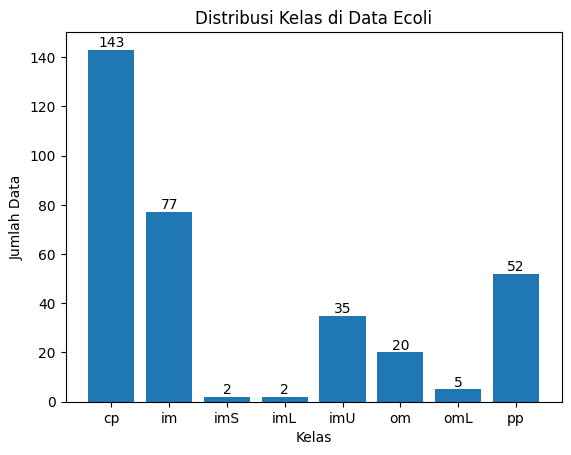

In [5]:
class_ecoli = ecoli_df["class"].unique()
distributed_data = []

for clas in class_ecoli:
    distributed_data.append(len(ecoli_df[ecoli_df["class"]  == clas]))

plt.bar(class_ecoli, distributed_data)

for i, v in enumerate(distributed_data):
    plt.text(i, v + 1.2, str(v), ha='center')

plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Kelas di Data Ecoli")

## Scatter Plot dari Data Ecoli

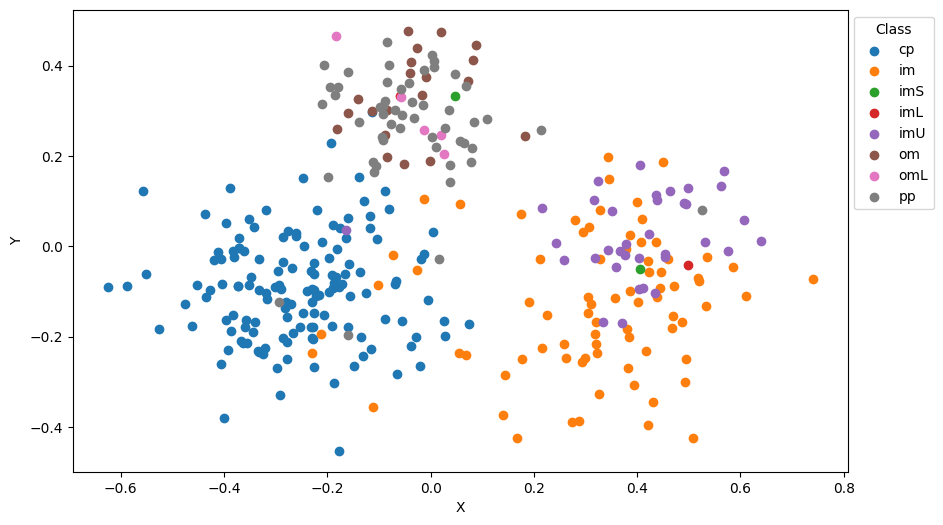

In [6]:
pca = PCA(n_components=2)

reduced = pd.DataFrame(pca.fit_transform(ecoli_df[fitur]))

# merge = np.hstack((reduced, ecoli_df["class"]))

reduced = reduced.merge(ecoli_df["class"], left_index=True, right_index=True)

plt.figure(figsize=(10, 6))
for i in reduced['class'].unique():
    plt.scatter(reduced[reduced["class"] == i][0], reduced[reduced["class"] == i][1], label=i)

plt.xlabel("X")
plt.ylabel("Y")

plt.legend(title="Class", bbox_to_anchor=(1.12,1), loc="upper right")

plt.show()

## Penyeimbangan Data menggunakan ADASYN

In [55]:
from imblearn.over_sampling import ADASYN

X = ecoli_df[fitur]
y = ecoli_df["class"]

x_resampled, y_resampled = ADASYN(n_neighbors=1, sampling_strategy={"imL": 2, "imS": 2, "omL": 2}).fit_resample(X, y)

# x_resampled, y_resampled = ADASYN(n_neighbors=1, sampling_strategy="not majority").fit_resample(x_resampled, y_resampled)

merge = x_resampled.merge(y_resampled, left_index=True, right_index=True)

merge


ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 5 samples and 2 samples are asked.

In [53]:
print(sorted(Counter(y_resampled).items()))

[('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 20), ('omL', 143), ('pp', 52)]


In [30]:
x_resampled, y_resampled = ADASYN(n_neighbors=1, sampling_strategy="not majority", random_state=42).fit_resample(x_resampled, y_resampled)

print(sorted(Counter(y_resampled).items()))

ValueError: No samples will be generated with the provided ratio settings.

In [10]:
x_resampled, y_resampled = ADASYN(n_neighbors=4, sampling_strategy="minority").fit_resample(x_resampled, y_resampled)

print(sorted(Counter(y_resampled).items()))

[('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 20), ('omL', 143), ('pp', 52)]


In [11]:
x_resampled, y_resampled = ADASYN(n_neighbors=19, sampling_strategy="minority").fit_resample(x_resampled, y_resampled)

print(sorted(Counter(y_resampled).items()))

[('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 143), ('omL', 143), ('pp', 52)]


In [12]:
x_resampled, y_resampled = ADASYN(n_neighbors=34, sampling_strategy="minority").fit_resample(x_resampled, y_resampled)

print(sorted(Counter(y_resampled).items()))

[('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 144), ('om', 143), ('omL', 143), ('pp', 52)]


In [13]:
x_resampled, y_resampled = ADASYN(n_neighbors=51, sampling_strategy="minority").fit_resample(x_resampled, y_resampled)

print(sorted(Counter(y_resampled).items()))

[('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 144), ('om', 143), ('omL', 143), ('pp', 144)]


In [17]:
x_resampled, y_resampled = ADASYN(n_neighbors=50, sampling_strategy="minority").fit_resample(x_resampled, y_resampled)

print(sorted(Counter(y_resampled).items()))

[('cp', 143), ('im', 137), ('imL', 142), ('imS', 142), ('imU', 144), ('om', 143), ('omL', 143), ('pp', 144)]


In [19]:
test = np.array(sorted(Counter(y_resampled).items()))

kelas, distribusi = np.hsplit(test, 2)

y_s = distribusi.astype(int).ravel().tolist()
x_s = kelas.ravel().tolist()
print(x_s)


['cp', 'im', 'imL', 'imS', 'imU', 'om', 'omL', 'pp']


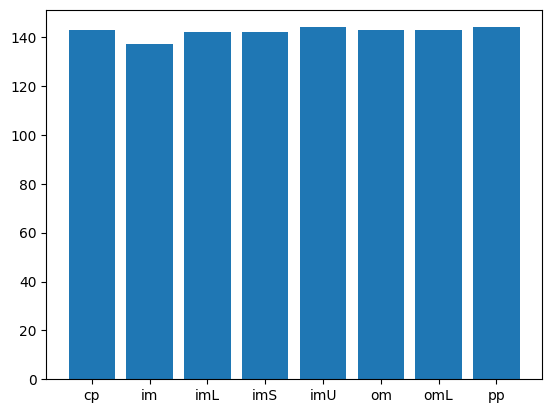

In [20]:
plt.bar(x_s, y_s)
plt.show()

In [82]:
x_resampled

,mcg,gvh,lip,chg,aac,alm1,alm2
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35
1,0.07,0.4,0.48,0.5,0.54,0.35,0.44
2,0.56,0.4,0.48,0.5,0.49,0.37,0.46
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35
...,...,...,...,...,...,...,...
1130,0.1099,0.4999,0.48,0.5,0.578299,0.7195,0.675298
1131,0.467764,0.488353,0.48,0.5,0.192707,0.712823,0.329177
1132,0.569736,0.499825,0.48,0.5,0.077546,0.794035,0.39009
1133,0.615244,0.628999,0.48,0.5,0.61639,0.771318,0.704269


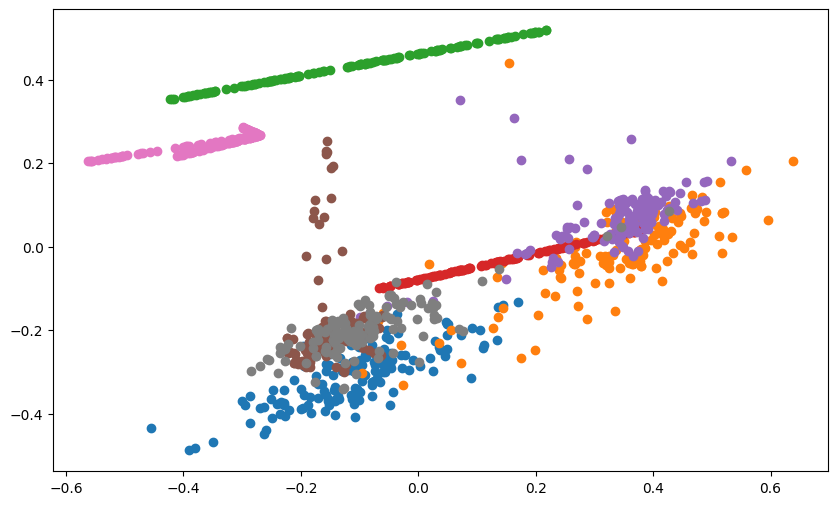

In [28]:

pca2 = PCA(n_components=2)


pcaData = pd.DataFrame(pca2.fit_transform(x_resampled)).merge(y_resampled, left_index=True, right_index=True)

plt.figure(figsize=(10, 6))

for i in x_s:
    subplot = pcaData[pcaData["class"] == i]
    plt.scatter(subplot[0], subplot[1], label=i)
    


In [56]:
new_ecoli_df = ecoli_df[ecoli_df["class"] != "imS"]
new_ecoli_df = new_ecoli_df[new_ecoli_df["class"] != "imL"]
new_ecoli_df = new_ecoli_df[new_ecoli_df["class"] != "omL"]

In [57]:
from imblearn.over_sampling import ADASYN

X = new_ecoli_df[fitur]
y = new_ecoli_df["class"]

x_resampled, y_resampled = ADASYN(n_neighbors=1, sampling_strategy="not majority").fit_resample(X, y)

merge = x_resampled.merge(y_resampled, left_index=True, right_index=True)

merge

,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.4,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.4,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp
...,...,...,...,...,...,...,...,...
706,0.62479,0.572292,0.48,0.5,0.475729,0.472292,0.515729,pp
707,0.593958,0.575095,0.48,0.5,0.482737,0.475095,0.522737,pp
708,0.465819,0.586744,0.48,0.5,0.511859,0.486744,0.551859,pp
709,0.646346,0.570332,0.48,0.5,0.47083,0.470332,0.51083,pp


In [58]:
print(sorted(Counter(y_resampled).items()))

[('cp', 143), ('im', 137), ('imU', 147), ('om', 144), ('pp', 140)]


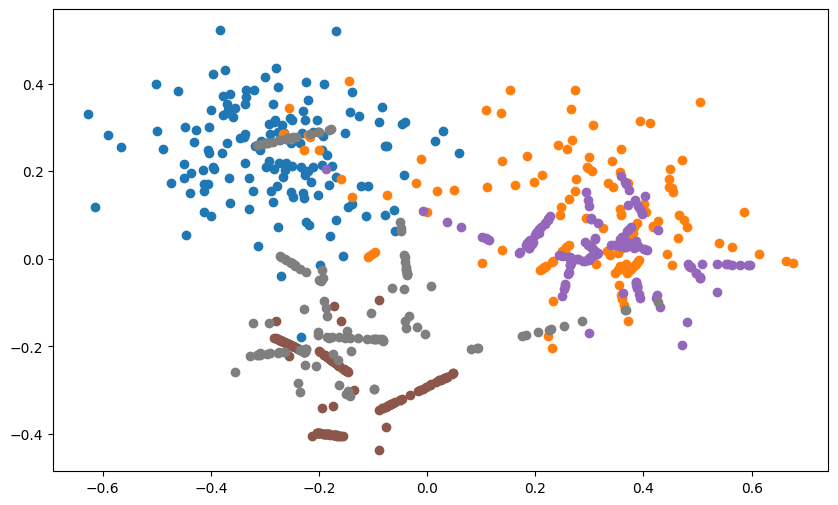

In [59]:

pca3 = PCA(n_components=2)


pcaData = pd.DataFrame(pca2.fit_transform(x_resampled)).merge(y_resampled, left_index=True, right_index=True)

plt.figure(figsize=(10, 6))

for i in x_s:
    subplot = pcaData[pcaData["class"] == i]
    plt.scatter(subplot[0], subplot[1], label=i)
    


In [66]:
from imblearn.over_sampling import SMOTE

p = ecoli_df[fitur]
q = ecoli_df["class"]

p_resampled, q_resampled = SMOTE(random_state=42, k_neighbors=1).fit_resample(X, y)

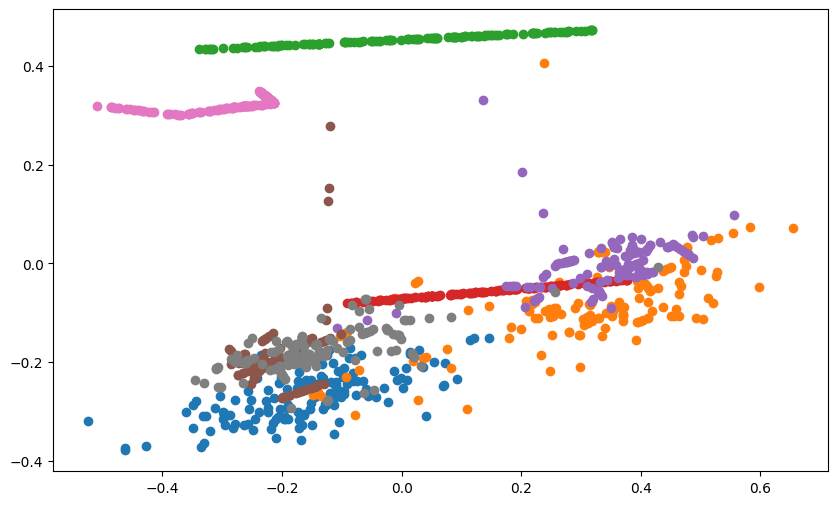

In [68]:

pca4 = PCA(n_components=2)


pca4Data = pd.DataFrame(pca2.fit_transform(p_resampled)).merge(q_resampled, left_index=True, right_index=True)

plt.figure(figsize=(10, 6))

for i in x_s:
    subplot = pca4Data[pca4Data["class"] == i]
    plt.scatter(subplot[0], subplot[1], label=i)
    

plt.show()